# <span style="color:red"> **Exploratory data analysis** </span>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import warnings


warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
dataset = pd.read_csv('/kaggle/input/creditgame-train/CreditGame_Train.csv')
dataset.head()

,ID_TRAIN,NB_EMPT,R_ATD,DUREE,PRT_VAL,AGE_D,REV_BT,REV_NET,TYP_RES,ST_EMPL,...,NB_DEL_90,MNT_PASS,MNT_ACT,MNT_AUT_REN,MNT_UTIL_REN,NB_SATI,TYP_FIN,MNT_DEMANDE,DEFAULT,PROFIT_LOSS
0,1,2,0.28,3,1.00,28.0,30000,27000,P,P,...,0,31645,51423,3500,3288,8,AUTO,19100,0,955.0
1,2,1,0.20,2,0.42,77.0,42000,24000,L,R,...,0,72,82890,4000,395,5,AUTO,21500,0,1075.0
2,3,1,0.29,5,0.86,48.0,87000,75000,P,R,...,0,218979,220951,10500,6186,3,AUTO,14300,0,715.0
3,4,1,0.07,4,0.92,26.0,89000,77000,P,R,...,0,301166,413887,2000,1687,5,AUTO,19500,0,975.0
4,5,1,0.19,5,1.00,39.0,86000,55000,P,P,...,0,302280,302544,46500,1740,5,AUTO,9000,0,450.0


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 31 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID_TRAIN      800000 non-null  int64  
 1   NB_EMPT       800000 non-null  int64  
 2   R_ATD         800000 non-null  float64
 3   DUREE         800000 non-null  int64  
 4   PRT_VAL       800000 non-null  float64
 5   AGE_D         783962 non-null  float64
 6   REV_BT        800000 non-null  int64  
 7   REV_NET       800000 non-null  int64  
 8   TYP_RES       800000 non-null  object 
 9   ST_EMPL       723300 non-null  object 
 10  MNT_EPAR      800000 non-null  int64  
 11  NB_ER_6MS     800000 non-null  int64  
 12  NB_ER_12MS    800000 non-null  int64  
 13  NB_DEC_12MS   800000 non-null  int64  
 14  NB_OPER       800000 non-null  int64  
 15  NB_COUR       800000 non-null  int64  
 16  NB_INTR_1M    800000 non-null  int64  
 17  NB_INTR_12M   800000 non-null  int64  
 18  PIR_

### **Is there any missing values ?**

In [4]:
dataset.isnull().sum()

ID_TRAIN            0
NB_EMPT             0
R_ATD               0
DUREE               0
PRT_VAL             0
AGE_D           16038
REV_BT              0
REV_NET             0
TYP_RES             0
ST_EMPL         76700
MNT_EPAR            0
NB_ER_6MS           0
NB_ER_12MS          0
NB_DEC_12MS         0
NB_OPER             0
NB_COUR             0
NB_INTR_1M          0
NB_INTR_12M         0
PIR_DEL             0
NB_DEL_30           0
NB_DEL_60           0
NB_DEL_90           0
MNT_PASS            0
MNT_ACT             0
MNT_AUT_REN         0
MNT_UTIL_REN        0
NB_SATI             0
TYP_FIN             0
MNT_DEMANDE         0
DEFAULT             0
PROFIT_LOSS         0
dtype: int64

<font size="4"> There are **16038** missing values in the age column and 76700 missing values in the employment status column. </font>

In [5]:
dataset["ST_EMPL"].value_counts(dropna=False)

ST_EMPL
R      380184
P      259930
T       83186
NaN     76700
Name: count, dtype: int64

<font size="4"> The different categories of the variable ST_EMPL (employment status) are: </font>      
- <font size="3"> R: regular </font>     
- <font size="3"> P: part-time </font>      
- <font size="3"> T: self-employed </font>    


<font size="4"> Several reasons could explain the existence of missing values in this variable. For example : unemployment, retirement, sick leave or disability etc... Therefore, instead of deleting these rows, we will rather group them together into a new category called O for Other** </font>

In [6]:
dataset['ST_EMPL'] = dataset['ST_EMPL'].fillna("O")
dataset["ST_EMPL"].value_counts(dropna=False)

ST_EMPL
R    380184
P    259930
T     83186
O     76700
Name: count, dtype: int64

<font size="4"> Regarding the variable AGE, explaining the existence of missing values is a bit more challenging. Before resorting to imputation, we will verify that the missing values process for this variable is not of the MNAR (Missing Not At Random) type.</font>

In [7]:
Z = np.where(dataset['AGE_D'].isna(), 1, 0)

dataset_intermed = pd.DataFrame({'Z': Z, 'DEFAULT': dataset['DEFAULT']})
dataset_intermed["Z"].value_counts()

Z
0    783962
1     16038
Name: count, dtype: int64

In [8]:
X = dataset_intermed[['Z']] 
y = dataset_intermed[['DEFAULT']]
X_with_const = sm.add_constant(X)

In [9]:
model = sm.Logit(y, X_with_const)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.198681
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                DEFAULT   No. Observations:               800000
Model:                          Logit   Df Residuals:                   799998
Method:                           MLE   Df Model:                            1
Date:                Sat, 25 May 2024   Pseudo R-squ.:               6.933e-07
Time:                        05:04:57   Log-Likelihood:            -1.5894e+05
converged:                       True   LL-Null:                   -1.5894e+05
Covariance Type:            nonrobust   LLR p-value:                    0.6387
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9429      0.005   -568.290      0.000      -2.953      -2.933
Z             -0.0173      0.

<font size="4"> The null hypothesis of this test is $H_0$ : $Z$ = 0 and the alternative hypothesis is $H_1$ : $Z$ $\ne$ 0. The test statitic is -0.468 and the corresponding p_value is 0.640. At $\alpha$  = 0.01, the p-value is less than alpha and we can reject the null hypothesis. In our context, this implies that the variable Z has no significant effect on defaulting or not. Therefore, the missing value process is not of the MNAR (Missing Not At Random) type.</font> 

# <span style="color:purple"> **1. Correlation analysis** </span>

In [10]:
colums_to_drop = ['ID_TRAIN', 'ST_EMPL', 'TYP_RES', 'TYP_FIN'] 
dataset_corr =  dataset.drop(columns=colums_to_drop)
dataset_corr.describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.90])

,NB_EMPT,R_ATD,DUREE,PRT_VAL,AGE_D,REV_BT,REV_NET,MNT_EPAR,NB_ER_6MS,NB_ER_12MS,...,NB_DEL_60,NB_DEL_90,MNT_PASS,MNT_ACT,MNT_AUT_REN,MNT_UTIL_REN,NB_SATI,MNT_DEMANDE,DEFAULT,PROFIT_LOSS
count,800000.000000,800000.000000,800000.000000,800000.000000,783962.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,...,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,1.134965,0.324668,3.991009,0.902833,37.545168,66081.745000,48113.938750,60501.194334,0.273086,0.545669,...,0.170478,0.107296,60077.962490,155462.492344,7483.486875,3511.947431,5.689969,22478.980125,0.050056,256.708756
std,0.341686,0.177397,1.795422,0.167102,14.918057,40797.418372,30891.597192,63807.138632,0.851316,1.308152,...,0.719022,0.539348,95949.191739,157982.609695,10408.501690,7013.691145,2.832542,10134.647508,0.218061,4461.672886
min,1.000000,0.000000,1.000000,0.400000,18.000000,4000.000000,2000.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5000.000000,0.000000,-39999.999970
10%,1.000000,0.090000,1.000000,0.590000,21.000000,21000.000000,15000.000000,2001.000000,0.000000,0.000000,...,0.000000,0.000000,865.000000,8425.900000,500.000000,0.000000,2.000000,8400.000000,0.000000,340.000000
25%,1.000000,0.200000,3.000000,0.890000,25.000000,38000.000000,27000.000000,10004.000000,0.000000,0.000000,...,0.000000,0.000000,2695.000000,36141.000000,1000.000000,55.000000,4.000000,13700.000000,0.000000,615.000000
50%,1.000000,0.330000,4.000000,1.000000,34.000000,56000.000000,41000.000000,37975.500000,0.000000,0.000000,...,0.000000,0.000000,12920.000000,107910.000000,4000.000000,825.000000,6.000000,22500.000000,0.000000,1080.000000
75%,1.000000,0.410000,5.000000,1.000000,48.000000,87000.000000,62000.000000,88049.000000,0.000000,0.000000,...,0.000000,0.000000,80845.000000,225461.250000,10000.000000,3739.000000,8.000000,31200.000000,0.000000,1540.000000
90%,2.000000,0.540000,6.000000,1.000000,60.000000,129000.000000,95000.000000,165161.000000,1.000000,2.000000,...,0.000000,0.000000,210079.100000,369710.400000,19000.000000,10000.000000,9.000000,36500.000000,0.000000,1815.000000
max,2.000000,0.940000,7.000000,1.000000,79.000000,179000.000000,163000.000000,249996.000000,6.000000,12.000000,...,6.000000,5.000000,499919.000000,999987.000000,80500.000000,80500.000000,14.000000,40000.000000,1.000000,2000.000000


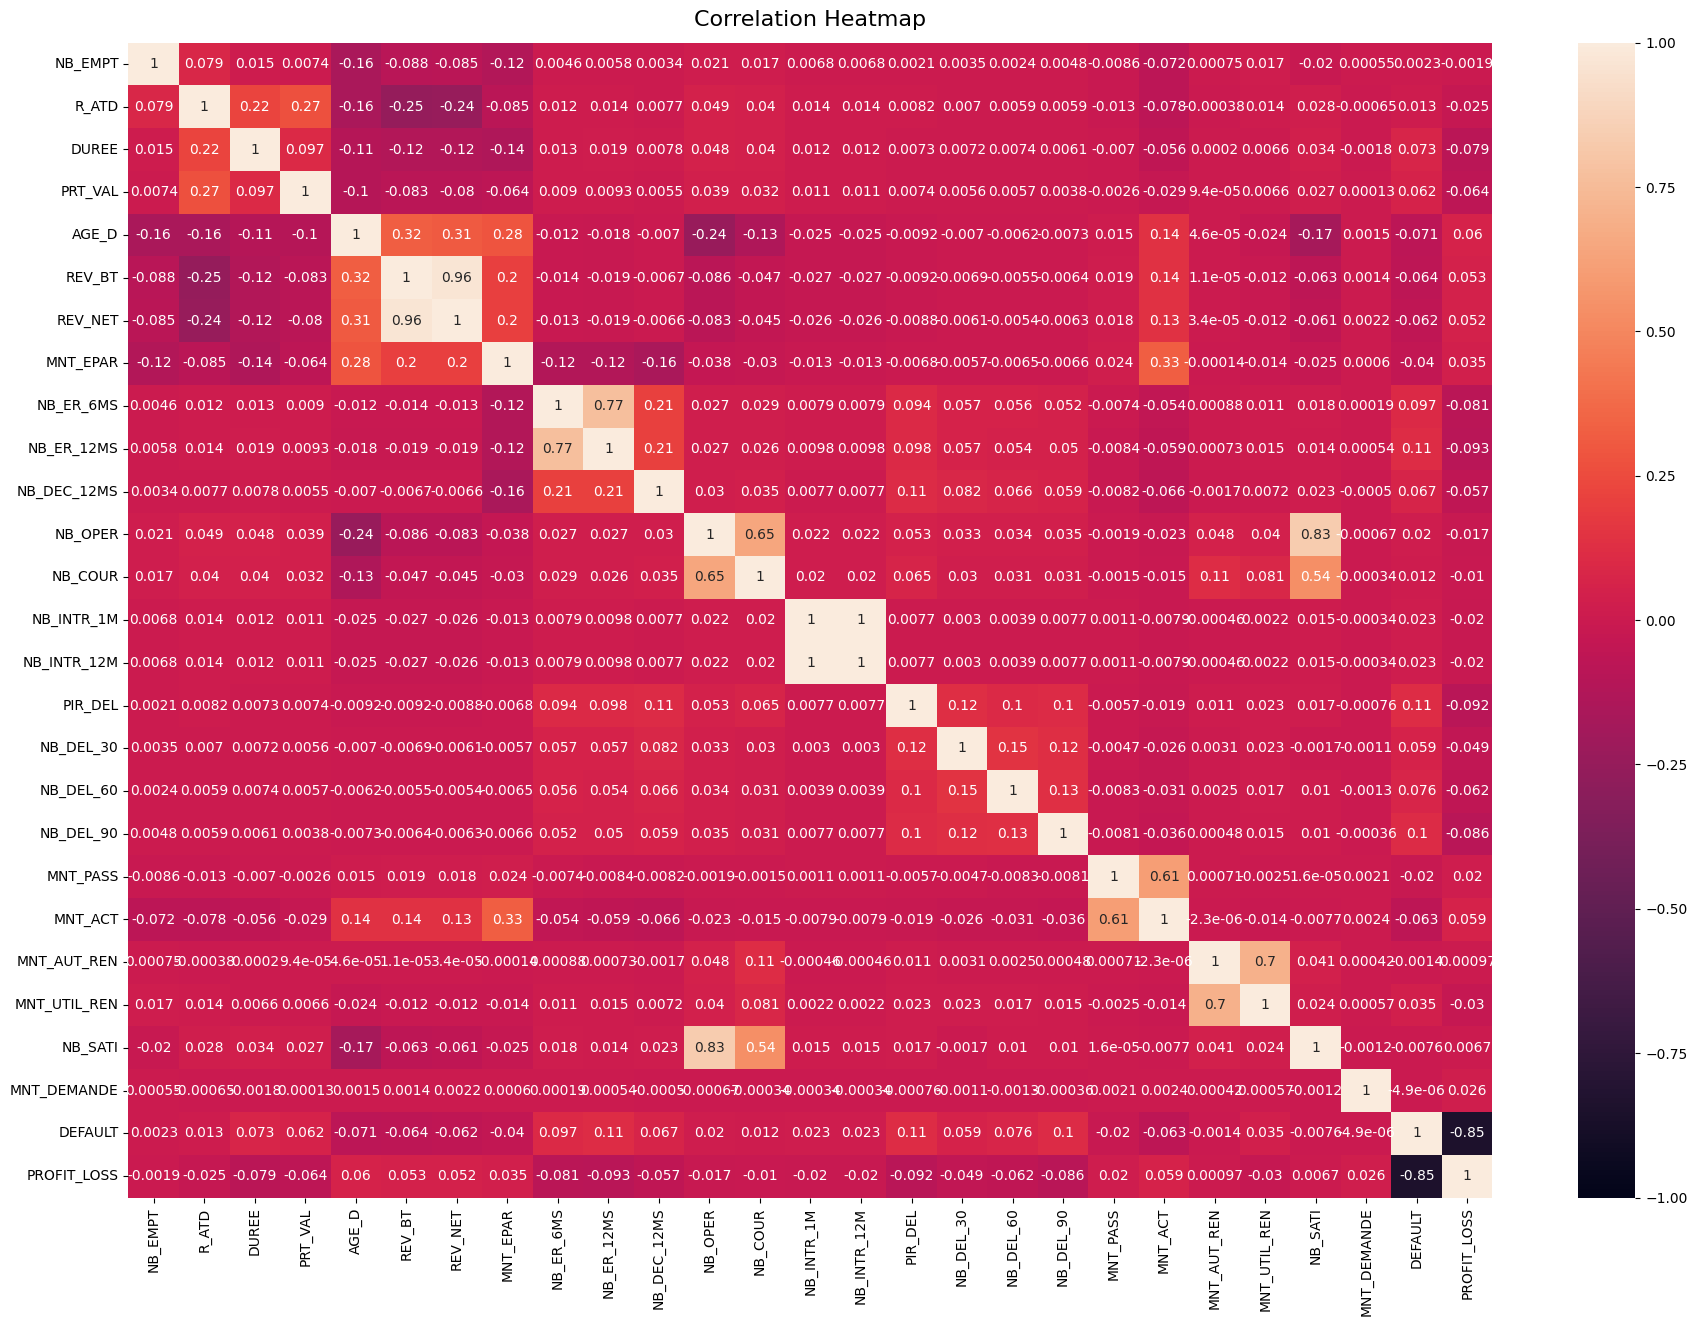

In [11]:
plt.figure(figsize=(22, 15))
heatmap = sns.heatmap(dataset_corr.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':16}, pad=12);

<font size="5"> **The following observations can be derived from the analysis of this correlation matrix:** </font>     

- <font size="4"> Without any surprise gross income (REV_BT) and net income (REV_NET) are **extremely correlated variables(0.96)**. Only one of them will be considered later in the modeling stage. </font>     

- <font size="4"> The total number of transactions (NB_OPER) and the total number of satisfactory transactions (NB_SATI) are **highly correlated (0.83)**. These two variables will be combined into a new one called RTS, representing their ratio (the number of satisfactory transactions over the total number of transactions). </font>      

- <font size="4"> The authorized amount of revolving credit (MNT_AUTO_REN) and the amount of revolving credit used (MNT_UTIL_REN) are **highly correlated (0.7)**. These two variables will be combined into a new one called RMU, representing their ratio (the amount of revolving credit used  over the authorized amount of revolving credit). </font>      

- <font size="4"> NB_INTR_1M (number of financing requests made during the last month) and NB_INTR_12M (number of financing requests made over the past 12 months) are **perfectly correlated** features. Since they provide identical information, only one them will be used later in the modeling stage. </font>      

- <font size="4"> Lastly, two pairs of variables (Assets (MNT_ACT)/Liabilities (MNT_PASS) and the number of transactions declined due to insufficient funds over the last 6 months (NB_ER_6MS)/the number of transactions declined due to insufficient funds over the last 12 months (NB_ER_12MS)) also present relatively high correlations. It will be important to keep this in mind later on during the modeling stage. </font>     

# <span style="color:purple"> **2. Multicollinearity analysis** </span>

In [12]:
med_age = dataset['AGE_D'].median()
dataset['AGE_D'] = dataset['AGE_D'].fillna(med_age)


dataset['RMU'] = np.where(dataset['MNT_AUT_REN'] == 0, 0, 
                          dataset['MNT_UTIL_REN'] / dataset['MNT_AUT_REN'])

dataset['RTS'] = np.where(dataset['NB_OPER'] == 0, 0, 
                          dataset['NB_SATI'] / dataset['NB_OPER'])

In [13]:
colums_to_drop = ['ID_TRAIN', 'ST_EMPL', 'TYP_RES', 'TYP_FIN', 'NB_INTR_1M',
                  'REV_NET', 'RMU', 'RTS', 'PROFIT_LOSS'] 
dataset_vif =  dataset.drop(columns=colums_to_drop)

vif = pd.DataFrame() 
vif["feature"] = dataset_vif.columns

In [14]:
vif["VIF"] = [variance_inflation_factor(dataset_vif.values, i) 
                          for i in range(len(dataset_vif.columns))] 

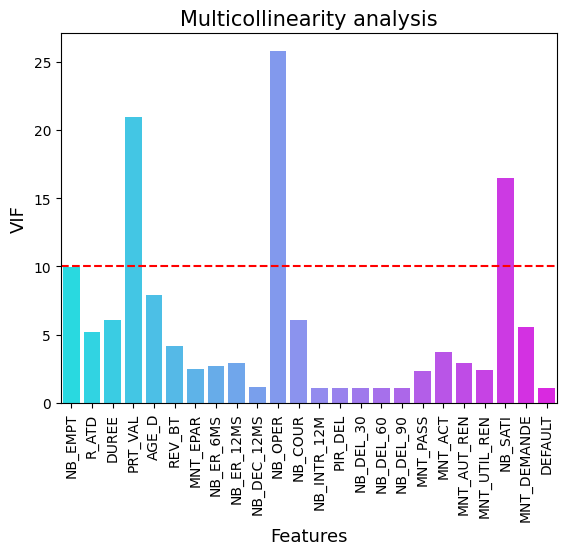

In [17]:
palette = 'cool'
sns.barplot(x = 'feature', y = 'VIF', data = vif, palette = palette)
plt.xticks(rotation=90)
plt.axhline(y=10, color='r', linestyle='--')
plt.title('Multicollinearity analysis', fontsize = 15)
plt.xlabel('Features', fontsize = 13)
plt.ylabel('VIF', fontsize = 13)
plt.show()

<font size="3">  Variables PRT_VAL, NB_OPER and NB_SATI have a variance inflation factor significantly greater than 10. This is quite problematic because a variance inflation factor greater than 10 implies that more than 90% of the variance of the variable in question is explained by the other explanatory variables. To potentially address this issue, the same analysis will be done but this time with the newly created variables. </font> 

In [18]:
colums_to_drop2 = ['ID_TRAIN', 'ST_EMPL', 'TYP_RES', 'TYP_FIN', 'NB_INTR_1M','REV_NET', 
                   'NB_OPER', 'NB_SATI', 'MNT_AUT_REN', 'MNT_UTIL_REN','PROFIT_LOSS'] 

dataset_vif2 =  dataset.drop(columns=colums_to_drop2)

vif2 = pd.DataFrame() 
vif2["feature"] = dataset_vif2.columns

In [19]:
vif2["VIF"] = [variance_inflation_factor(dataset_vif2.values, i) 
                          for i in range(len(dataset_vif2.columns))] 

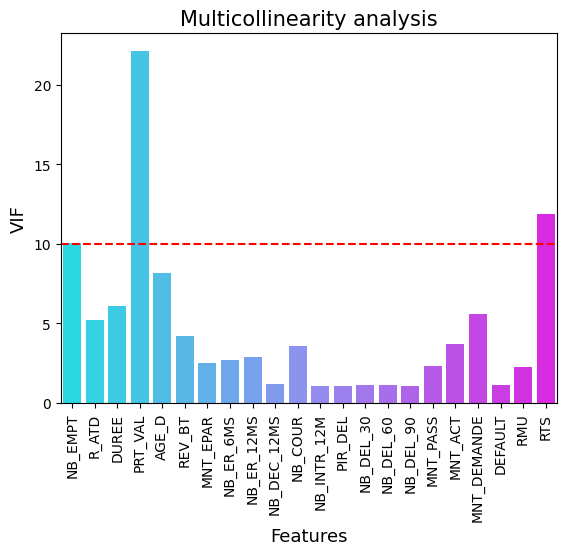

In [20]:
palette = 'cool'    
sns.barplot(x = 'feature', y = 'VIF', data = vif2, palette = palette)
plt.xticks(rotation=90)
plt.axhline(y=10, color='r', linestyle='--')
plt.title('Multicollinearity analysis', fontsize = 15)
plt.xlabel('Features', fontsize = 13)
plt.ylabel('VIF', fontsize = 13)
plt.show()

<font size="3">  The creation of a new variable (RTS), representing the ratio of variables NB_SATI and NB_OPER, has mitigated the multicollinearity issue for these two variables but (VIF) of RTS remains slightly above 10. Regarding the variable PRT_VAL, the VIF has remained very high. </font> 

In [21]:
colums_to_drop3 = ['ID_TRAIN', 'ST_EMPL', 'TYP_RES', 'TYP_FIN', 'NB_INTR_1M', 'PRT_VAL','REV_NET', 
                   'NB_OPER', 'NB_SATI', 'MNT_AUT_REN', 'MNT_UTIL_REN', 'PROFIT_LOSS'] 

dataset_vif3 =  dataset.drop(columns=colums_to_drop3)

vif3 = pd.DataFrame() 
vif3["feature"] = dataset_vif3.columns

In [22]:
vif3["VIF"] = [variance_inflation_factor(dataset_vif3.values, i) 
                          for i in range(len(dataset_vif3.columns))] 

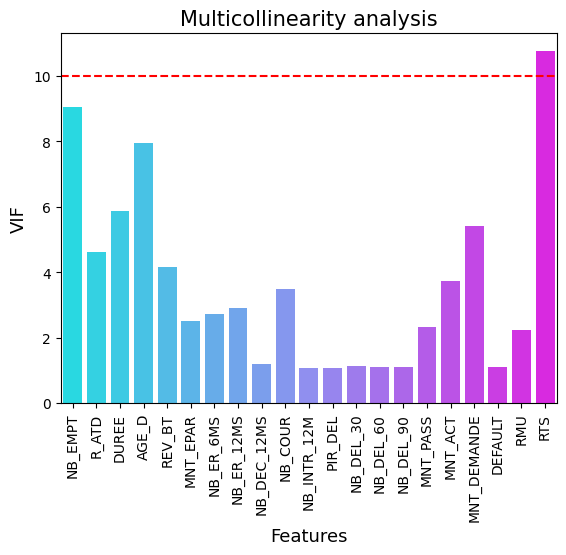

In [23]:
palette = 'cool'    
sns.barplot(x = 'feature', y = 'VIF', data = vif3, palette = palette)
plt.xticks(rotation=90)
plt.axhline(y=10, color='r', linestyle='--')
plt.title('Multicollinearity analysis', fontsize = 15)
plt.xlabel('Features', fontsize = 13)
plt.ylabel('VIF', fontsize = 13)
plt.show()

# <span style="color:purple"> **3. Univariate analysis** </span>

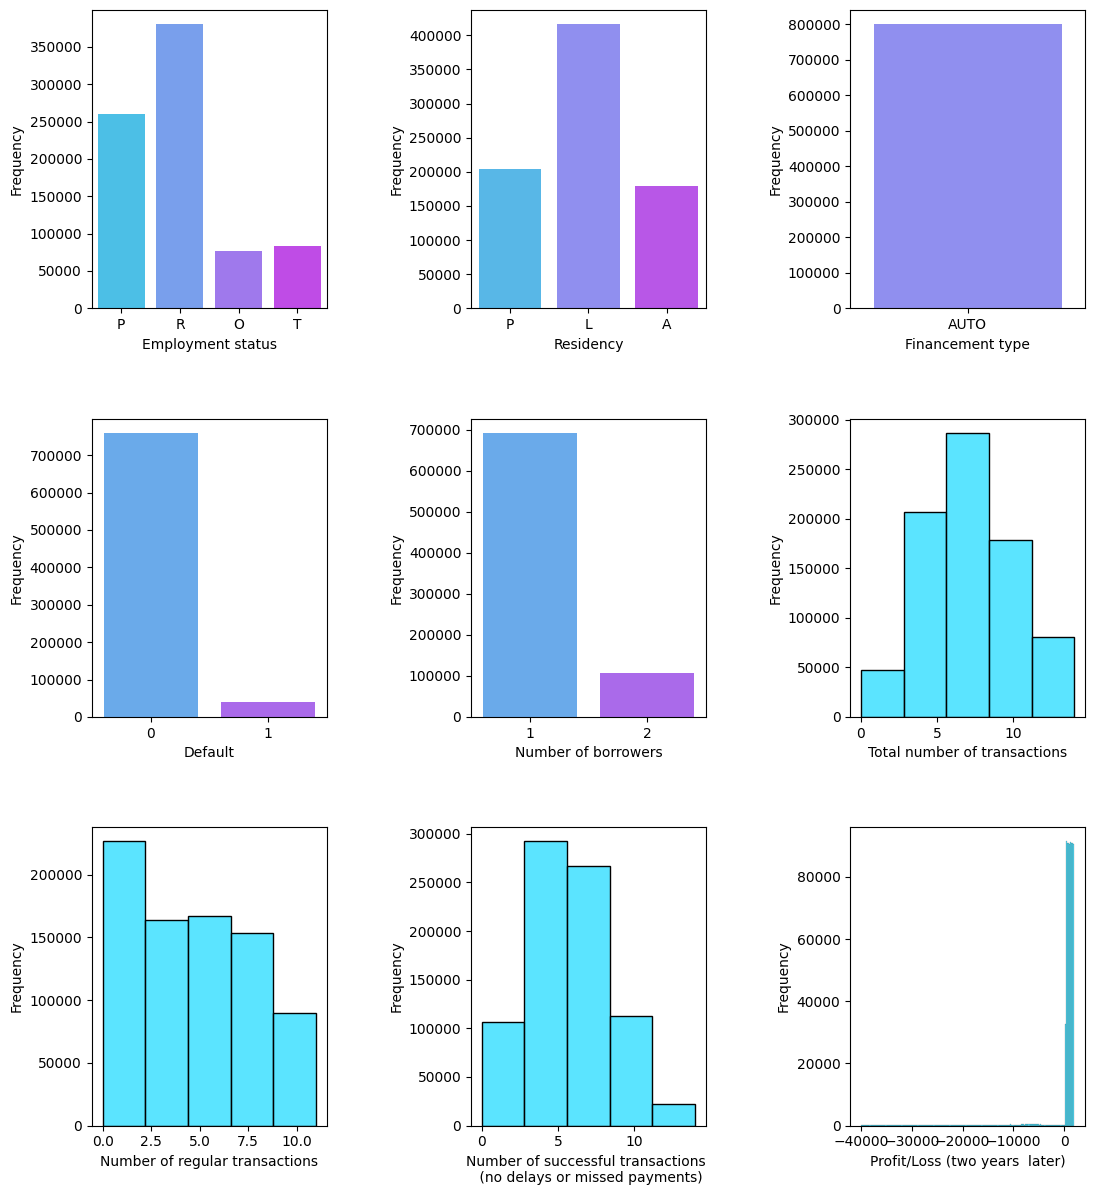

In [37]:
palette = 'cool'

sns.set_palette(palette)

fig, ax = plt.subplots(3, 3, figsize=(12,13))

sns.countplot(ax=ax[0,0], data=dataset, x="ST_EMPL", palette=palette)
ax[0,0].set_xlabel("Employment status")
ax[0,0].set_ylabel("Frequency")

sns.countplot(ax=ax[0,1], data=dataset, x="TYP_RES", palette=palette)
ax[0,1].set_xlabel("Residency")
ax[0,1].set_ylabel("Frequency")

sns.countplot(ax=ax[0,2], data=dataset, x="TYP_FIN", palette=palette)
ax[0,2].set_xlabel("Financement type")
ax[0,2].set_ylabel("Frequency")

sns.countplot(ax=ax[1,0], data=dataset, x="DEFAULT", palette=palette)
ax[1,0].set_xlabel("Default")
ax[1,0].set_ylabel("Frequency")

sns.countplot(ax=ax[1,1], data=dataset, x="NB_EMPT", palette=palette)
ax[1,1].set_xlabel("Number of borrowers")
ax[1,1].set_ylabel("Frequency")

sns.histplot(ax=ax[1,2], data=dataset, x="NB_OPER", bins = 5)
ax[1,2].set_xlabel("Total number of transactions")
ax[1,2].set_ylabel("Frequency")

sns.histplot(ax=ax[2,0], data=dataset, x="NB_COUR", bins = 5)
ax[2,0].set_xlabel("Number of regular transactions")
ax[2,0].set_ylabel("Frequency")

sns.histplot(ax=ax[2,1], data=dataset, x="NB_SATI", bins = 5)
ax[2,1].set_xlabel("Number of successful transactions \n (no delays or missed payments)")
ax[2,1].set_ylabel("Frequency")

sns.histplot(ax=ax[2,2], data=dataset, x="PROFIT_LOSS", bins = 200)
ax[2,2].set_xlabel("Profit/Loss (two years  later)")
ax[2,2].set_ylabel("Frequency")

fig.tight_layout(pad=4.5)

In [25]:
dataset['DEFAULT'].value_counts() / len(dataset)

DEFAULT
0    0.949944
1    0.050056
Name: count, dtype: float64

In [26]:
profit = dataset[dataset['PROFIT_LOSS'] > 0]
loss = dataset[dataset['PROFIT_LOSS'] < 0]

profit_mean = profit['PROFIT_LOSS'].mean()
profit_loss = loss['PROFIT_LOSS'].mean()

print("Average profit :", profit_mean)
print("Average loss :", profit_loss)

Average profit : 1123.9495759617346
Average loss : -16201.375833664275


- <font size="3"> The DEFAULT variable presents a **noticeable imabalance**. Out of the 800 000 borrowers or pairs of borrowers in our database, 759 955 have kept up with their payment plans while only 40 045 have defaulted (95% paying back and only 5% defaulting). Therefore, it will be crucial not only to focus on the accuracy rate of the chosen model but also to ensure that it effectively identifies individuals at risk of default. </font>      

- <font size="3"> In addition, average losses are higher than average profits. Since our goal is to maximize profits, we need to find the appropriate balance between the false negative rate and the false positive rate. The cost (loss incurred) of failing to predict a future default is higher than the cost (potential profit lost) of falsely predicting a default. </font>      

- <font size="3"> Since all financing requests are for automobiles, the variable FIN_TYPE will not be considered further in this project as it does not provide any additional information. </font>     

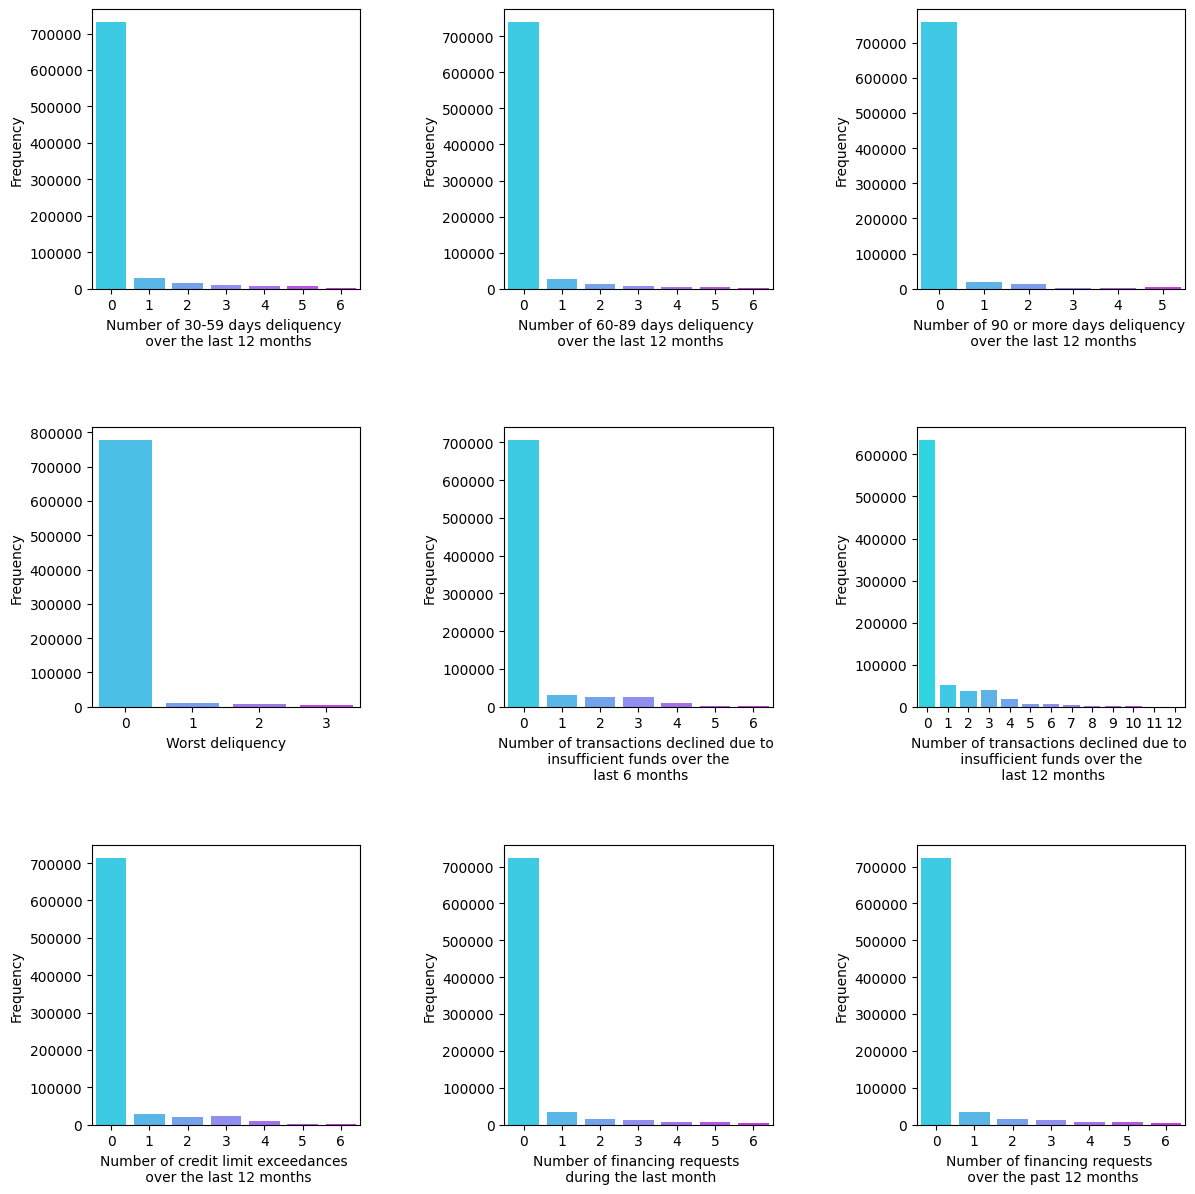

In [27]:
palette = 'cool'

sns.set_palette(palette)

fig, ax = plt.subplots(3, 3, figsize=(13,13))

sns.countplot(ax = ax[0,0], data=dataset, x="NB_DEL_30", palette=palette)
ax[0,0].set_xlabel("Number of 30-59 days deliquency \n over the last 12 months")
ax[0,0].set_ylabel("Frequency")


sns.countplot(ax = ax[0,1], data=dataset, x="NB_DEL_60", palette=palette)
ax[0,1].set_xlabel("Number of 60-89 days deliquency \n over the last 12 months")
ax[0,1].set_ylabel("Frequency")


sns.countplot(ax = ax[0,2], data=dataset, x="NB_DEL_90", palette=palette)
ax[0,2].set_xlabel("Number of 90 or more days deliquency \n over the last 12 months")
ax[0,2].set_ylabel("Frequency")


sns.countplot(ax = ax[1,0], data=dataset, x="PIR_DEL", palette=palette)
ax[1,0].set_xlabel("Worst deliquency")
ax[1,0].set_ylabel("Frequency")


sns.countplot(ax = ax[1,1], data=dataset, x="NB_ER_6MS", palette=palette)
ax[1,1].set_xlabel("Number of transactions declined due to \n insufficient funds over the \n last 6 months")
ax[1,1].set_ylabel("Frequency")


sns.countplot(ax = ax[1,2], data=dataset, x="NB_ER_12MS", palette=palette)
ax[1,2].set_xlabel("Number of transactions declined due to \n insufficient funds over the \n last 12 months")
ax[1,2].set_ylabel("Frequency")


sns.countplot(ax = ax[2,0], data=dataset, x="NB_DEC_12MS", palette=palette)
ax[2,0].set_xlabel("Number of credit limit exceedances \n over the last 12 months")
ax[2,0].set_ylabel("Frequency")


sns.countplot(ax = ax[2,1], data=dataset, x="NB_INTR_1M", palette=palette)
ax[2,1].set_xlabel("Number of financing requests \n during the last month")
ax[2,1].set_ylabel("Frequency")


sns.countplot(ax = ax[2,2], data=dataset, x="NB_INTR_12M", palette=palette)
ax[2,2].set_xlabel("Number of financing requests \n over the past 12 months")
ax[2,2].set_ylabel("Frequency")


fig.tight_layout(pad=4.5)

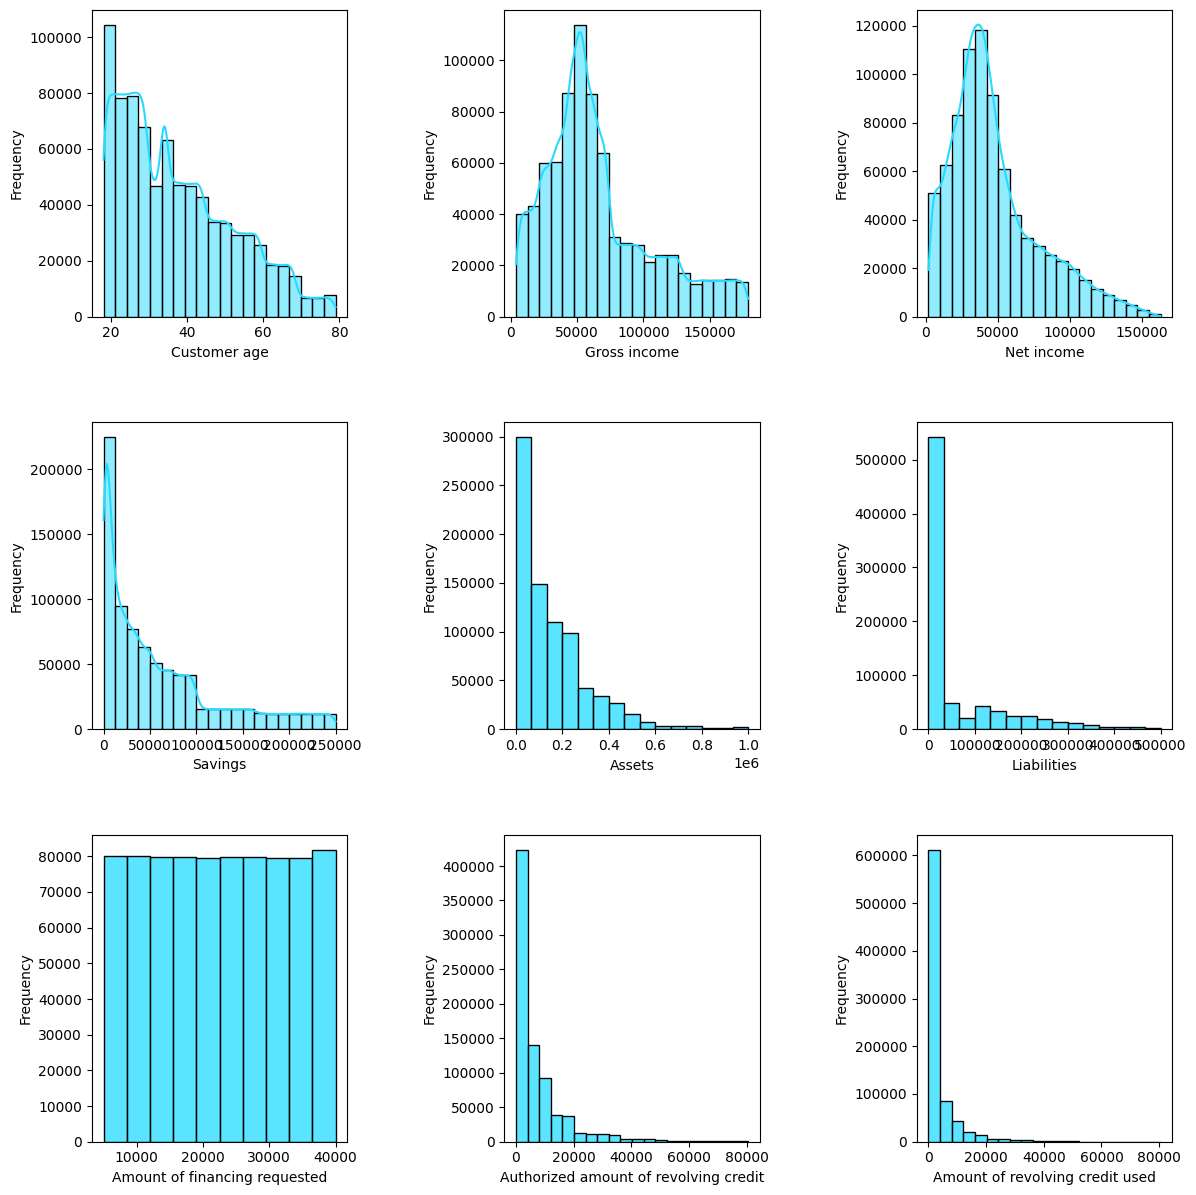

In [28]:
palette = 'cool'

sns.set_palette(palette)

fig, ax = plt.subplots(3, 3, figsize=(13,13))

sns.histplot(ax = ax[0,0], data=dataset, x="AGE_D", bins = 20, kde = True)
ax[0,0].set_xlabel("Customer age")
ax[0,0].set_ylabel("Frequency")

sns.histplot(ax = ax[0,1], data=dataset, x="REV_BT", bins = 20, kde = True)
ax[0,1].set_xlabel("Gross income")
ax[0,1].set_ylabel("Frequency")

sns.histplot(ax = ax[0,2], data=dataset, x="REV_NET", bins = 20, kde = True)
ax[0,2].set_xlabel("Net income")
ax[0,2].set_ylabel("Frequency")

sns.histplot(ax = ax[1,0], data=dataset, x="MNT_EPAR", bins = 20, kde = True)
ax[1,0].set_xlabel("Savings")
ax[1,0].set_ylabel("Frequency")

sns.histplot(ax = ax[1,1], data=dataset, x="MNT_ACT", bins = 15)
ax[1,1].set_xlabel("Assets")
ax[1,1].set_ylabel("Frequency")

sns.histplot(ax = ax[1,2], data=dataset, x="MNT_PASS", bins = 15)
ax[1,2].set_xlabel("Liabilities")
ax[1,2].set_ylabel("Frequency")

sns.histplot(ax = ax[2,0], data=dataset, x="MNT_DEMANDE", bins = 10)
ax[2,0].set_xlabel("Amount of financing requested")
ax[2,0].set_ylabel("Frequency")

sns.histplot(ax = ax[2,1], data=dataset, x="MNT_AUT_REN", bins = 20)
ax[2,1].set_xlabel("Authorized amount of revolving credit")
ax[2,1].set_ylabel("Frequency")

sns.histplot(ax = ax[2,2], data=dataset, x="MNT_UTIL_REN", bins = 20)
ax[2,2].set_xlabel("Amount of revolving credit used")
ax[2,2].set_ylabel("Frequency")

fig.tight_layout(pad=4.5)

# <span style="color:purple"> **4. Bivariate analysis** </span>

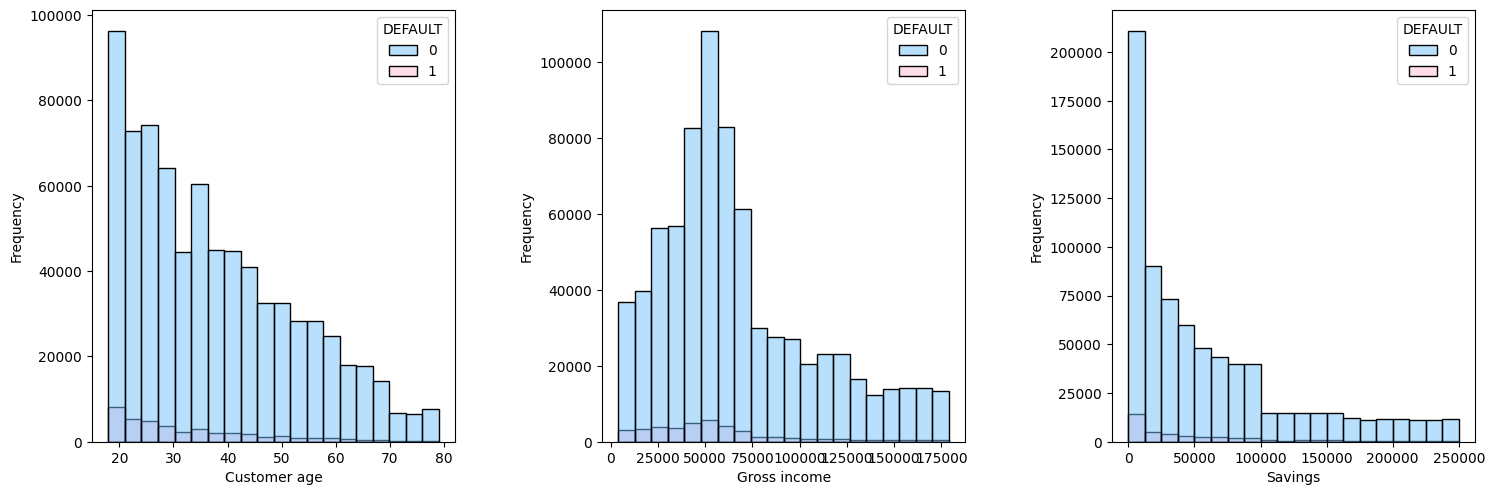

In [32]:
custom_palette = ['#73c2fb', '#ffbcd9']

sns.set_palette(custom_palette)

fig, ax = plt.subplots(1, 3, figsize=(16,6))

sns.histplot(ax = ax[0], data=dataset, x="AGE_D", hue = 'DEFAULT', bins = 20)
ax[0].set_xlabel("Customer age")
ax[0].set_ylabel("Frequency")

sns.histplot(ax = ax[1], data=dataset, x="REV_BT", hue = 'DEFAULT', bins = 20)
ax[1].set_xlabel("Gross income")
ax[1].set_ylabel("Frequency")

sns.histplot(ax = ax[2], data=dataset, x="MNT_EPAR", hue = 'DEFAULT', bins = 20)
ax[2].set_xlabel("Savings")
ax[2].set_ylabel("Frequency")


fig.tight_layout(pad=4.5)